In [1]:
# from pyincore import IncoreClient, DataService, SpaceService, HazardService, Dataset, FragilityService, Mapping, MappingSet, FragilityCurveSet, GeoUtil, Flood, NetworkDataset, NetworkUtil
from pyincore import IncoreClient, Dataset, FragilityService, Mapping, MappingSet, FragilityCurveSet
from pyincore.analyses.buildingdamage import BuildingDamage
# from pyincore.analyses.meandamage import MeanDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 

from pyincore_viz.plotutil import PlotUtil as plot
from pyincore_viz.geoutil import GeoUtil as viz

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import norm, lognorm
import os
import json
import rasterio
import networkx as nx
import contextily as cx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from rasterio.features import geometry_mask
from shapely.geometry import Point, LineString, box
# from shapely.ops import nearest_points

In [2]:
from utility_functions import *

In [3]:
client = IncoreClient()
# data_services = DataService(client)
# space_services = SpaceService(client)
# fragility_services = FragilityService(client)
# hazardsvc = HazardService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.19.0


## Input Building Data

In [4]:
buildings_local = Dataset.from_file("input_data/sample_buildings.shp", data_type="ergo:buildingInventoryVer4")
buildings_df = buildings_local.get_dataframe_from_shapefile().set_index('uid')
buildings_df.head(3)

Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
uid                                                                          
1       House1  38.980200 -76.485999           0       2      30      RES3   
2       House2  38.979932 -76.485676           0       2      30      RES3   
3       House3  38.979717 -76.485350           0       2      30      RES3   

     From_Node                    geometry  
uid                                         
1            6     POINT (-76.486 38.9802)  
2            6  POINT (-76.48568 38.97993)  
3            6  POINT (-76.48535 38.97972)

In [5]:
# ax = buildings_df.plot(figsize=(20, 10), color = 'Red', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

## Input Power Network

In [6]:
# Regional Power Grid Nodes and Links
epf_dataset = Dataset.from_file("input_data/epf_nodes_updated.shp", data_type="ergo:nodeInventoryVer1")
epf_gdf = epf_dataset.get_dataframe_from_shapefile().set_index('uid')
epn_dataset = Dataset.from_file("input_data/epn_links_updated.shp", data_type="ergo:edgeInventoryVer1")
epn_gdf = epn_dataset.get_dataframe_from_shapefile()

# Local Power Network Connecting Distribution Substations to Buildings
edges_bldg_subs_dataset = Dataset.from_file("input_data/subs_to_bldgs_edges.shp", data_type="ergo:edgeInventoryVer1")
edges_bldg_subs_df = edges_bldg_subs_dataset.get_dataframe_from_shapefile()

In [7]:
edges_bldg_subs_df

inode_subs  jnode_buil           linetype  \
0            6           1  Transmission Line   
1            6           2  Transmission Line   
2            6           3  Transmission Line   
3            6           4  Transmission Line   
4            6           5  Transmission Line   
5            6           6  Transmission Line   
6            6           7  Transmission Line   
7            6           8  Transmission Line   
8            6           9  Transmission Line   
9            6          10  Transmission Line   
10           6          11  Transmission Line   
11           6          12  Transmission Line   
12           6          13  Transmission Line   
13           6          14  Transmission Line   

                                             geometry  
0    LINESTRING (-76.49102 38.99094, -76.486 38.9802)  
1   LINESTRING (-76.49102 38.99094, -76.48568 38.9...  
2   LINESTRING (-76.49102 38.99094, -76.48535 38.9...  
3   LINESTRING (-76.49102 38.99094, -76.48506 38.9...  
4   LINESTRING (-76.49102 38.99094, -76.48472 38.9...  
5   LINESTRING (-76.49102 38.99094, -76.48444 38.9...  
6   LINESTRING (-76.49102 38.99094, -76.48489 38.9...  
7   LINESTRING (-76.49102 38.99094, -76.48289 38.9...  
8   LINESTRING (-76.49102 38.99094, -76.48726 38.9...  
9   LINESTRING (-76.49102 38.99094, -76.48673 38.9...  
10  LINESTRING (-76.49102 38.99094, -76.48779 38.9...  
11  LINESTRING (-76.49102 38.99094, -76.48804 38.9...  
12  LINESTRING (-76.49102 38.99094, -76.48612 38.9...  
13  LINESTRING (-76.49102 38.99094, -76.48653 38.9...

## Input Transportation Network Data

In [8]:
# get link dataset from data service
node_dataset = Dataset.from_file("input_data/nodes.shp", data_type="ergo:nodeInventoryVer1")
nodes_df = node_dataset.get_dataframe_from_shapefile()

# get link dataset from data service
edge_dataset = Dataset.from_file("input_data/edges.shp", data_type="ergo:edgeInventoryVer1")
edge_df = edge_dataset.get_dataframe_from_shapefile()

In [9]:
nodes_df = nodes_df.rename(columns = {'osmid': 'nodenwid'})
edge_df = edge_df.rename(columns = {'osmid': 'linknwid',
                           'u': 'fromnode',
                           'v': 'tonode'})

g = create_networkx_graph(nodes_df, edge_df)

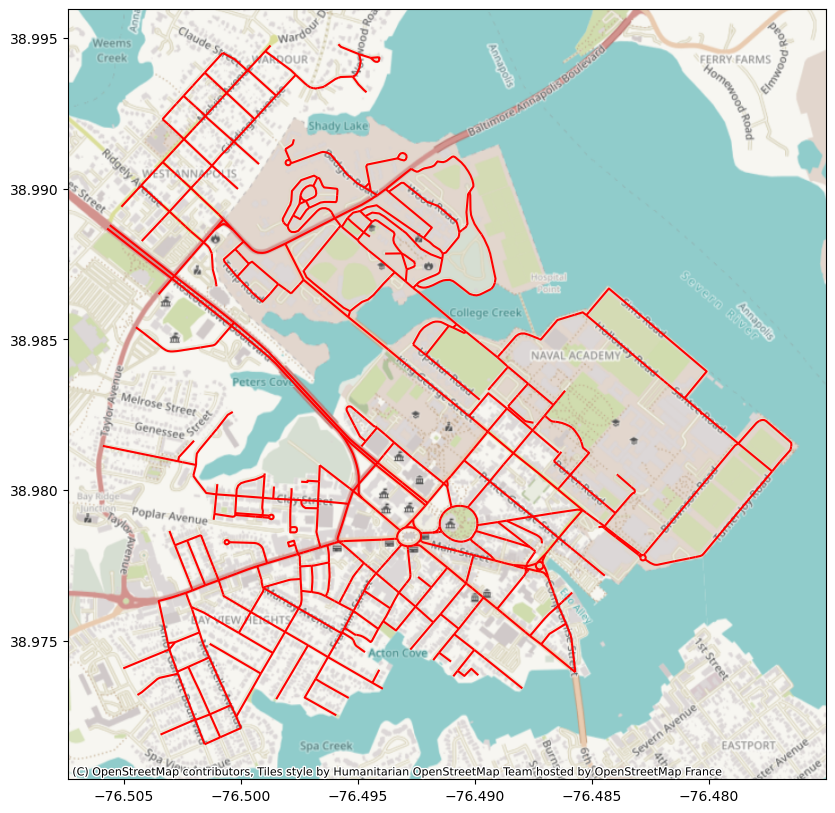

In [10]:
### Plot Transportation Network shapefiles
# ax = nodes_df.plot(figsize=(20, 10), column='inundationDepth', categorical=True, markersize=20, legend=True, cmap = 'Blues')
ax = edge_df.plot(figsize=(20, 10), color='r')
cx.add_basemap(ax, crs=nodes_df.crs)

## Import Elevation Data

The elevation map is saved in the form of a raster file that can be read into the Notebook and the values of the raster can be attached to the individual structural locations based on proximity.

In [11]:
raster_path = 'input_data/USGS_1_n39w077_20220713.tif'

buildings_df = attach_flood_hazard(buildings_df, 
                                   raster_path, 
                                   raster_value = 'elevation')

epf_gdf = attach_flood_hazard(epf_gdf, 
                                     raster_path, 
                                     raster_value = 'elevation')

## Input Hazard Data

The hazard map is saved in the form of a raster file that can be read into the Notebook and the values of the raster can be attached to the individual structural locations based on proximity.

In [12]:
raster_path = 'input_data/cat4_high_raster.tif'

buildings_df = attach_flood_hazard(buildings_df, raster_path, raster_value = 'water_depth')
buildings_df['inundationDepth'] = buildings_df['water_depth'] - buildings_df['elevation']
buildings_df['inundationDepth'] = buildings_df['inundationDepth'].apply(lambda x: max(x, 0))
buildings_df.head(3)

Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
uid                                                                          
1       House1  38.980200 -76.485999           0       2      30      RES3   
2       House2  38.979932 -76.485676           0       2      30      RES3   
3       House3  38.979717 -76.485350           0       2      30      RES3   

     From_Node                    geometry  elevation  water_depth  \
uid                                                                  
1            6     POINT (-76.486 38.9802)   2.569192     2.827191   
2            6  POINT (-76.48568 38.97993)   1.930152     2.827191   
3            6  POINT (-76.48535 38.97972)   1.807689     2.827191   

     inundationDepth  
uid                   
1           0.257999  
2           0.897038  
3           1.019502

In [13]:
# # viz.plot_gdf_map(buildings_df, column='inundationDepth')
# ### Plot EPN shapefiles
# ax = buildings_df.plot(figsize=(20, 10), column='inundationDepth', categorical=True, markersize=150, legend=True, cmap = 'Blues')
# cx.add_basemap(ax, crs=nodes_df.crs)

In [14]:
epf_gdf = attach_flood_hazard(epf_gdf, raster_path, raster_value = 'water_depth')
epf_gdf['inundationDepth'] = epf_gdf['water_depth'] - epf_gdf['elevation']
epf_gdf['inundationDepth'] = epf_gdf['inundationDepth'].apply(lambda x: max(x, 0))
epf_gdf

Name   Latitude  Longitude  \
uid                                                              
1             Calvert Cliffs Power Plant  38.431945 -76.441607   
2    Herbert A Wagner Generating Station  39.177846 -76.525819   
3                BGE Bestgate Substation  38.992267 -76.547425   
4                  Arnold BGE Substation  39.037100 -76.481000   
5        BGE Greenburry Point Substation  38.996257 -76.473759   
6          BGE US Navy Severn Substation  38.990940 -76.491020   
7              BGE Cedar Park Substation  38.979300 -76.501500   
8             BGE Tyer Avenue Substation  38.960900 -76.491900   

                           Type From_Node               facility_t  \
uid                                                                  
1           Nuclear Power Plant      None              Power Plant   
2    Coal and Natural Gas Plant      None              Power Plant   
3                  Transmission      1, 2  Transmission Substation   
4                  Distribution         2  Distribution Substation   
5                  Distribution         2  Distribution Substation   
6                  Distribution         3  Distribution Substation   
7                  Distribution         3  Distribution Substation   
8                  Distribution         1  Distribution Substation   

                       geometry  elevation  water_depth  inundationDepth  
uid                                                                       
1    POINT (-76.44161 38.43194)  18.118330     7.731699         0.000000  
2    POINT (-76.52582 39.17785)   1.624268     7.312860         5.688592  
3    POINT (-76.54742 38.99227)  26.499935     0.000000         0.000000  
4       POINT (-76.481 39.0371)   0.000000     0.000000         0.000000  
5    POINT (-76.47376 38.99626)  23.132006     0.000000         0.000000  
6    POINT (-76.49102 38.99094)   1.356403    14.029014        12.672611  
7      POINT (-76.5015 38.9793)   9.689898     0.000000         0.000000  
8      POINT (-76.4919 38.9609)   4.651736     3.160006         0.000000

In [15]:
nodes_df = attach_flood_hazard(nodes_df, raster_path)
nodes_df.head(3)

# edge_df = attach_flood_hazard(edge_df, raster_path)
# edge_df

nodenwid          y          x highway   ref                    geometry  \
0  7185334298  38.985016 -76.487252    None  None  POINT (-76.48725 38.98502)   
1   102629495  38.992313 -76.499406    None  None  POINT (-76.49941 38.99231)   
2   102629499  38.990768 -76.501229    None  None  POINT (-76.50123 38.99077)   

   inundationDepth  
0        14.029014  
1         3.067575  
2         0.000000

## Fragility Model Definition

### Buildings

In [16]:
fragility_curve_set1, fragility_curve_set2, local_building_mapping_set = get_building_fragility()

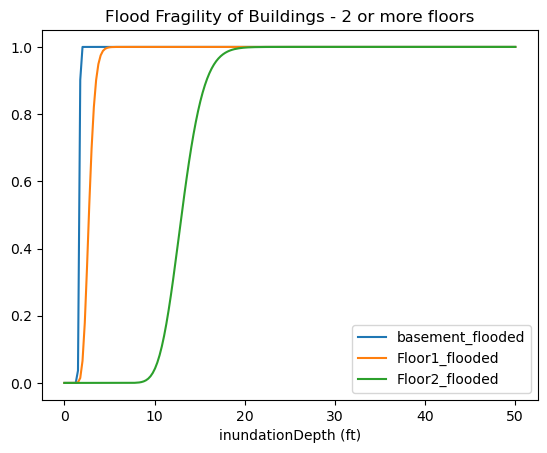

In [17]:
plt = plot.get_fragility_plot(fragility_curve_set1, start=0, end=50)

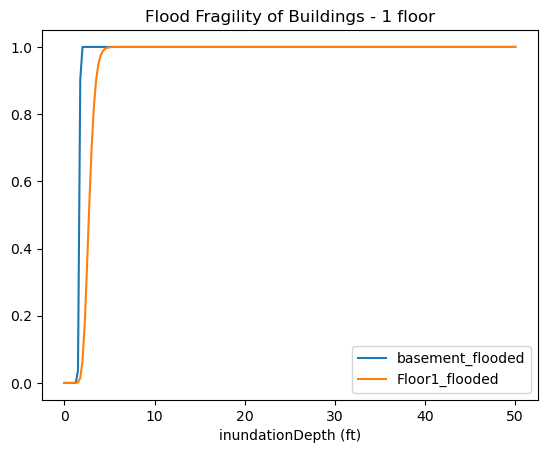

In [18]:
plt = plot.get_fragility_plot(fragility_curve_set2, start=0, end=50)

### Substations

In [19]:
fragility_curve_set_substations = get_substation_fragility()

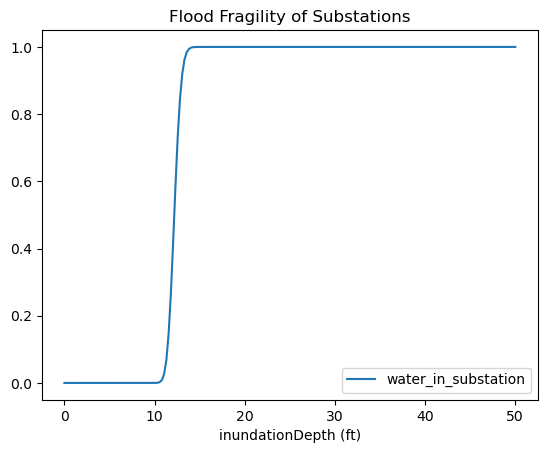

In [20]:
plt = plot.get_fragility_plot(fragility_curve_set_substations, start=0, end=50)

### Roads

In [21]:
fragility_curve_set_roads = get_road_fragility()

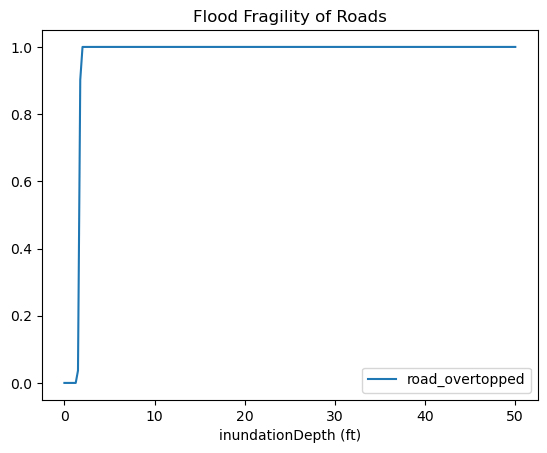

In [22]:
plt = plot.get_fragility_plot(fragility_curve_set_roads, start=0, end=50)

## Perform Damage Analysis

### Buildings

In [23]:
buildings_df = run_building_damage_analysis(buildings_df, local_building_mapping_set)
buildings_df.head(3)

Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
uid                                                                          
1       House1  38.980200 -76.485999           0       2      30      RES3   
2       House2  38.979932 -76.485676           0       2      30      RES3   
3       House3  38.979717 -76.485350           0       2      30      RES3   

     From_Node                    geometry  elevation  water_depth  \
uid                                                                  
1            6     POINT (-76.486 38.9802)   2.569192     2.827191   
2            6  POINT (-76.48568 38.97993)   1.930152     2.827191   
3            6  POINT (-76.48535 38.97972)   1.807689     2.827191   

     inundationDepth  LS_0          LS_1  LS_2  DS_0          DS_1  \
uid                                                                  
1           0.257999   0.0  0.000000e+00   0.0   1.0  0.000000e+00   
2           0.897038   0.0  1.480000e-08   0.0   1.0 -1.480000e-08   
3           1.019502   0.0  4.709000e-07   0.0   1.0 -4.709000e-07   

             DS_2  DS_3  
uid                      
1    0.000000e+00   0.0  
2    1.480000e-08   0.0  
3    4.709000e-07   0.0

In [24]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_2', legend=True, cmap = 'Reds', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

### Substations

In [25]:
epf_gdf = run_substation_damage_analysis(epf_gdf, fragility_curve_set_substations)

In [26]:
epf_gdf

Name   Latitude  Longitude  \
uid                                                              
1             Calvert Cliffs Power Plant  38.431945 -76.441607   
2    Herbert A Wagner Generating Station  39.177846 -76.525819   
3                BGE Bestgate Substation  38.992267 -76.547425   
4                  Arnold BGE Substation  39.037100 -76.481000   
5        BGE Greenburry Point Substation  38.996257 -76.473759   
6          BGE US Navy Severn Substation  38.990940 -76.491020   
7              BGE Cedar Park Substation  38.979300 -76.501500   
8             BGE Tyer Avenue Substation  38.960900 -76.491900   

                           Type From_Node               facility_t  \
uid                                                                  
1           Nuclear Power Plant      None              Power Plant   
2    Coal and Natural Gas Plant      None              Power Plant   
3                  Transmission      1, 2  Transmission Substation   
4                  Distribution         2  Distribution Substation   
5                  Distribution         2  Distribution Substation   
6                  Distribution         3  Distribution Substation   
7                  Distribution         3  Distribution Substation   
8                  Distribution         1  Distribution Substation   

                       geometry  elevation  water_depth  inundationDepth  \
uid                                                                        
1    POINT (-76.44161 38.43194)  18.118330     7.731699         0.000000   
2    POINT (-76.52582 39.17785)   1.624268     7.312860         5.688592   
3    POINT (-76.54742 38.99227)  26.499935     0.000000         0.000000   
4       POINT (-76.481 39.0371)   0.000000     0.000000         0.000000   
5    POINT (-76.47376 38.99626)  23.132006     0.000000         0.000000   
6    POINT (-76.49102 38.99094)   1.356403    14.029014        12.672611   
7      POINT (-76.5015 38.9793)   9.689898     0.000000         0.000000   
8      POINT (-76.4919 38.9609)   4.651736     3.160006         0.000000   

         LS_0      DS_0      DS_1  
uid                                
1    0.000000  1.000000  0.000000  
2    0.000000  1.000000  0.000000  
3    0.000000  1.000000  0.000000  
4    0.000000  1.000000  0.000000  
5    0.000000  1.000000  0.000000  
6    0.784903  0.215097  0.784903  
7    0.000000  1.000000  0.000000  
8    0.000000  1.000000  0.000000

In [27]:
epn_gdf

fromnode  tonode           linetype  \
0         1       3  Transmission Line   
1         2       3  Transmission Line   
2         2       4  Transmission Line   
3         2       5  Transmission Line   
4         3       6  Distribution Line   
5         3       7  Distribution Line   
6         1       8  Transmission Line   

                                            geometry  
0  LINESTRING (-76.44161 38.43194, -76.46264 38.5...  
1  LINESTRING (-76.52582 39.17785, -76.53015 39.1...  
2  LINESTRING (-76.52582 39.17785, -76.51684 39.1...  
3  LINESTRING (-76.52582 39.17785, -76.51539 39.1...  
4  LINESTRING (-76.54742 38.99227, -76.53614 38.9...  
5  LINESTRING (-76.54742 38.99227, -76.53824 38.9...  
6  LINESTRING (-76.44161 38.43194, -76.45161 38.5...

### Buildings Power

In [28]:
buildings_df, epf_gdf = run_buildings_power(epf_gdf, epn_gdf, buildings_df, edges_bldg_subs_df)

In [29]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_power', legend=True, cmap = 'Reds', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

### Roads

In [30]:
edge_df = run_road_damage_analysis(edge_df, fragility_curve_set_roads)

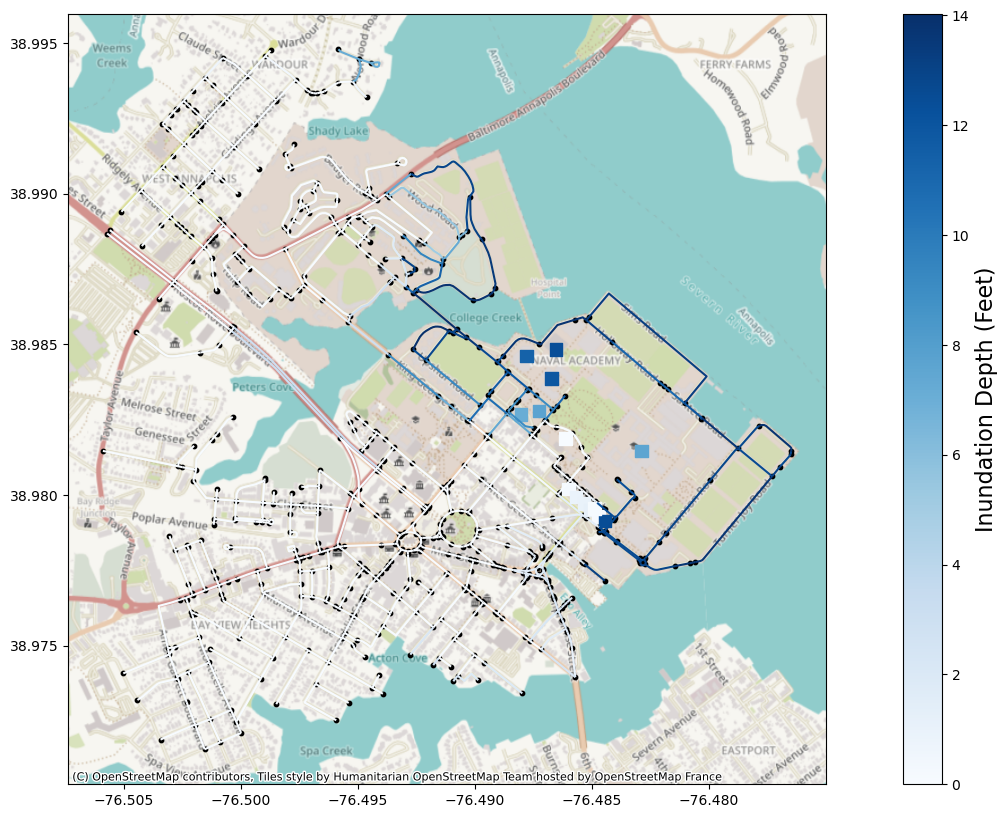

In [31]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.Blues
norm = mcolors.Normalize(vmin=0.0, vmax=edge_df['inundationDepth'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='inundationDepth', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='inundationDepth', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Inundation Depth (Feet)", fontsize=16)
# ax.set_title('Map Showing Probability of Failure for Roads and Probability of 1st Floor Flooding in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)

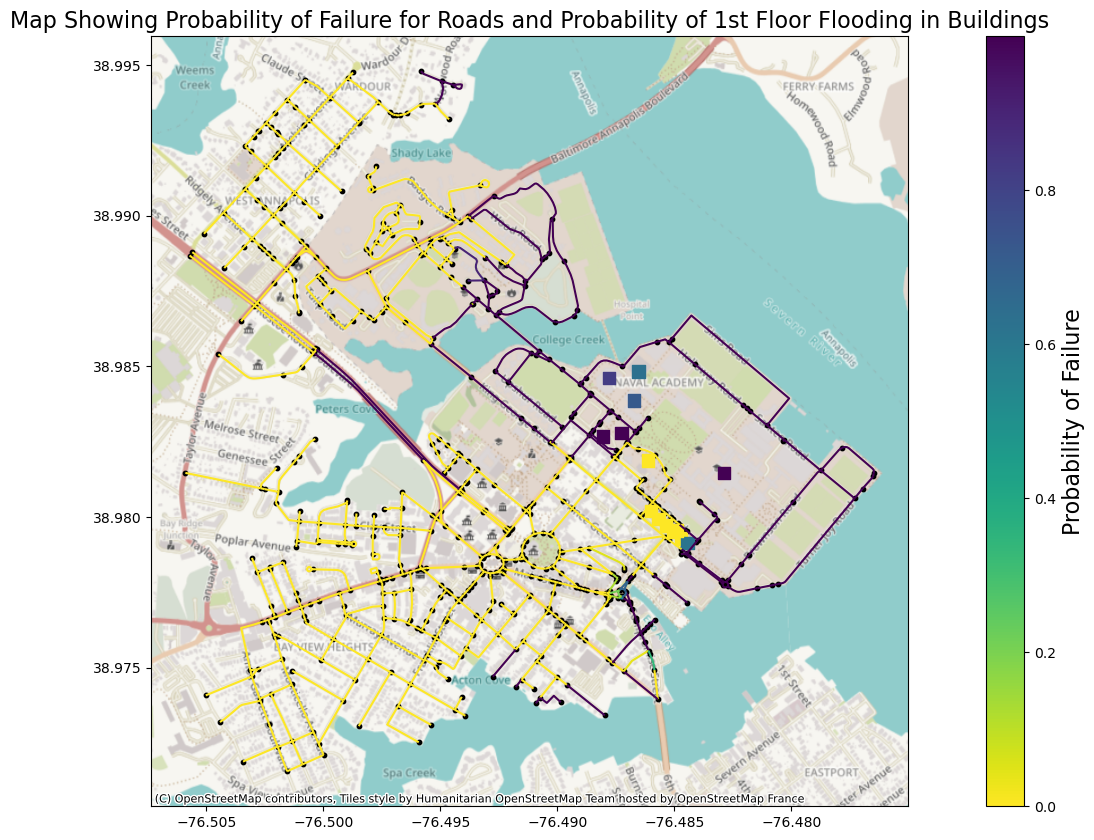

In [32]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['DS_2'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='DS_1', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='DS_2', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Probability of Failure", fontsize=16)
ax.set_title('Map Showing Probability of Failure for Roads and Probability of 1st Floor Flooding in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

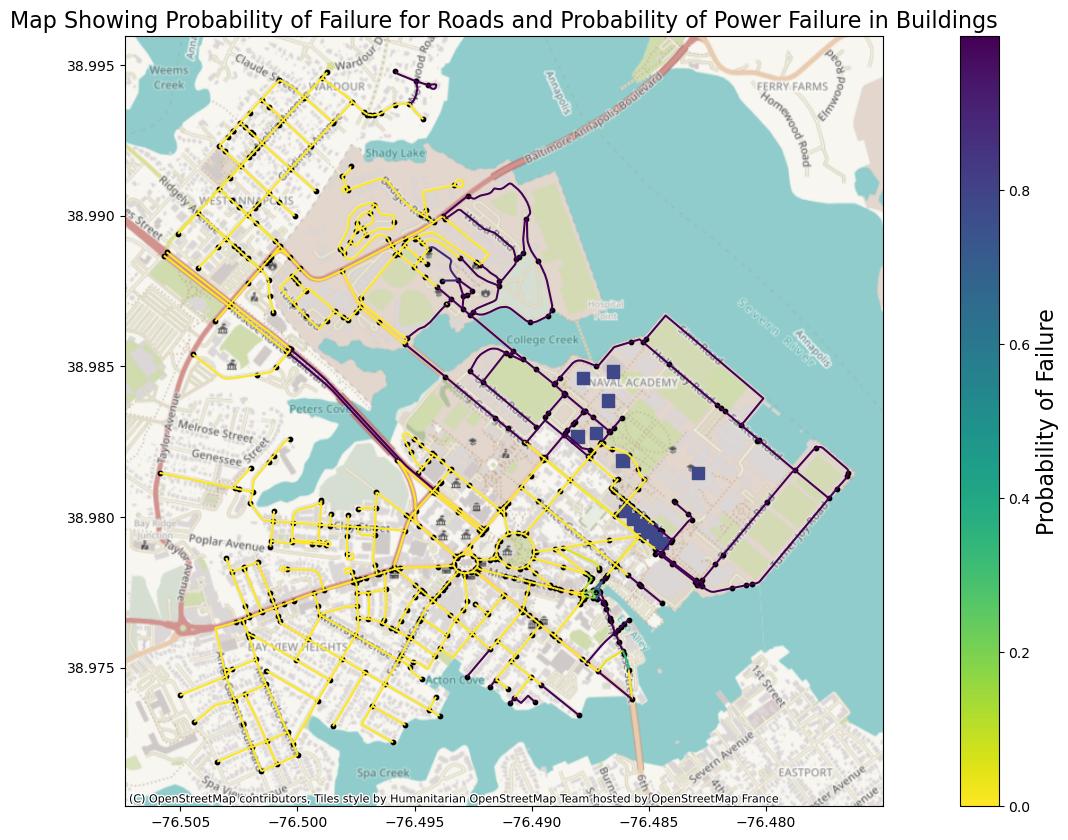

In [33]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['DS_2'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='DS_1', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='DS_powerfail', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Probability of Failure", fontsize=16)
ax.set_title('Map Showing Probability of Failure for Roads and Probability of Power Failure in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

## Monte Carlo Simulation

In [34]:
num_samples = 100

### Building Failure Simulations

In [35]:
buildings_df_mc = montecarloFailureSim(buildings_df.copy(), 
                                   ["DS_0", "DS_1", "DS_2", "DS_3"],
                                   num_samples)

### Building Power Failure Simulations

In [36]:
buildings_df_mc = montecarloFailureSim(buildings_df.copy(), 
                                   ["DS_nopower", "DS_power"],
                                   num_samples)

### Transportation Failure Simulations

In [37]:
edge_df_mc = montecarloFailureSim(edge_df.copy(), 
                               ["DS_0", "DS_1"],
                               num_samples)

## Network Resilience Metric Computation

In [38]:
# Create Networkx graph object from nodes and edges database
G = create_networkx_graph(nodes_df, edge_df)

In [39]:
### Add nearest network node ID to buildings GeoDataFrame
buildings_df['nearest_node'] = buildings_df.apply(
    lambda row: find_nearest_network_node(row, nodes_df), axis=1
)

building_nodes = np.array(nodes_df.loc[buildings_df['nearest_node'], 'nodenwid'])

# Identify the edge nodes in the network
boundary_nodes = np.array([node for node, degree in G.degree() if degree == 1])
boundary_nodes = boundary_nodes[~np.isin(boundary_nodes, building_nodes)]

In [40]:
results_pristine = compute_shortest_paths(G, building_nodes, boundary_nodes)
efficiency_pristine = (1 / results_pristine['Weight'].replace([float('inf'), -float('inf')], float('nan'))).sum()

In [41]:
resilience_metric = []
for simnum in range(num_samples):
    edge_df_mc['sample'] =edge_df_mc.iloc[:, -1].apply(lambda x: x[simnum] if x else None)
    edge_df_mc = edge_df_mc[edge_df_mc['sample'] != 1].reset_index(drop = True)

    G_temp = create_networkx_graph(nodes_df, edge_df_mc)
    # results = compute_shortest_paths(G_temp, building_nodes, boundary_nodes)
    # edge_df_mc = edge_df_mc.drop(columns = ['sample'])
    # efficiency = (1 / results['Weight'].replace([float('inf'), -float('inf')], float('nan'))).sum()

    # relative_efficiency = efficiency/efficiency_pristine
    relative_connectivity = count_connected_pairs(G_temp)
    
    # resilience_metric.append(relative_efficiency)
    resilience_metric.append(relative_connectivity)
    del G_temp
    

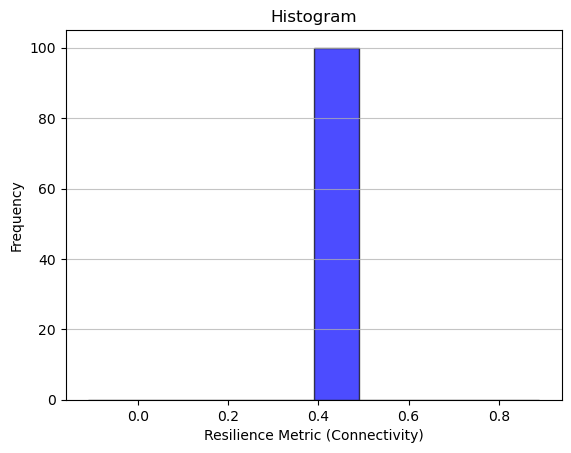

In [42]:
plt.hist(resilience_metric, bins = 10, color = 'blue', edgecolor = 'black', alpha = 0.7)
# Customize the plot
plt.title('Histogram')
plt.xlabel('Resilience Metric (Connectivity)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show plot
plt.show()

## Recovery Models

In [43]:
# buildings_df = building_recovery_model(buildings_df)
# buildings_df = building_power_recovery_model(buildings_df)
# edge_df = road_recovery_model(edge_df)

In [44]:
buildings_df = get_recovery_curve_buildings(buildings_df)
buildings_df = get_recovery_curve_power(buildings_df)
edge_df = get_recovery_curve_roads(edge_df)

C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:687: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1840000302409948e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_df.loc[i, 'mean_downtime'] = mean_downtime_days
C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:688: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001650212103381498' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_df.loc[i, 'std_downtime'] = stdev_downtime_days
C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:796: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001070797033638986' has dtype incompatible with int64, p

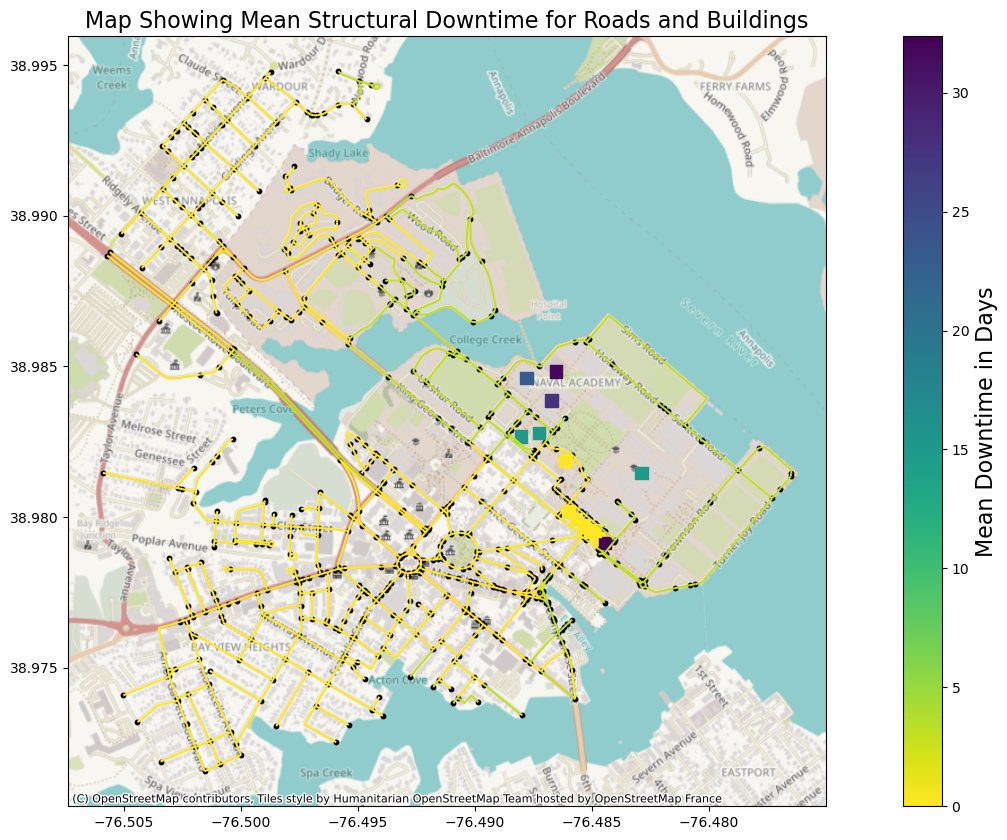

In [45]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['mean_downtime'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='mean_downtime', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='mean_downtime', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Mean Downtime in Days", fontsize=16)
ax.set_title('Map Showing Mean Structural Downtime for Roads and Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

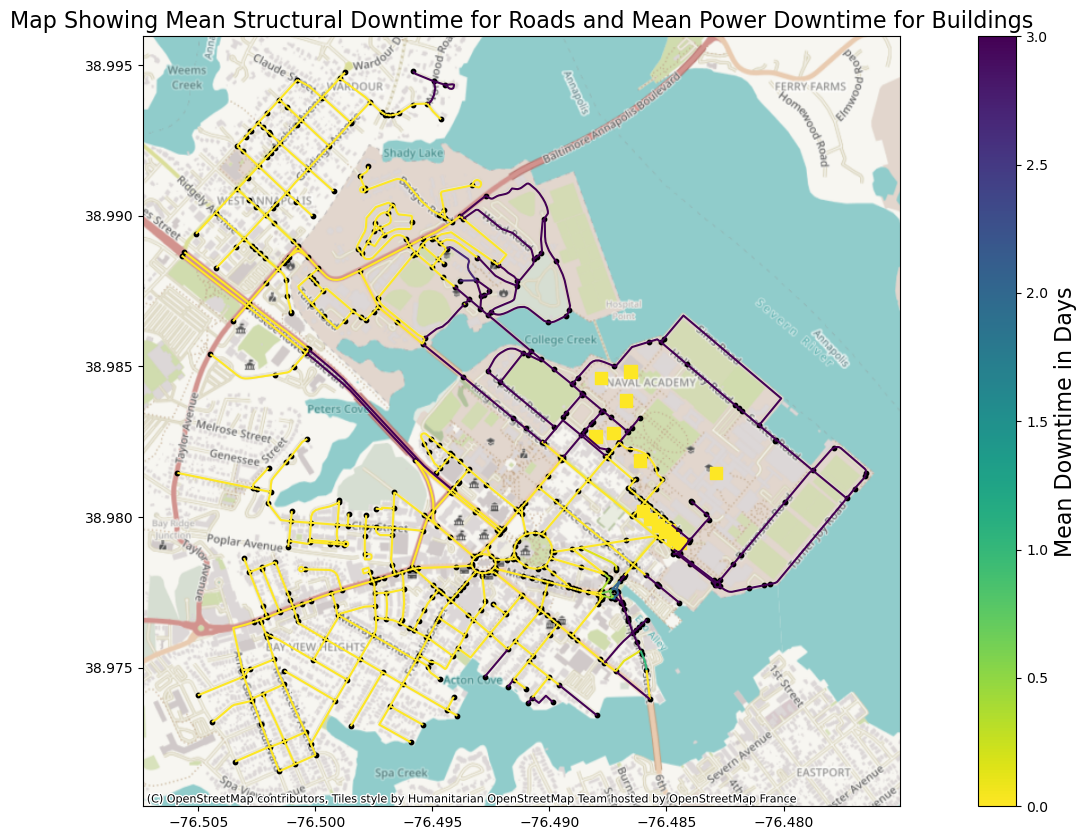

In [46]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=edge_df['mean_downtime'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='mean_downtime', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='mean_downtime_power', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Mean Downtime in Days", fontsize=16)
ax.set_title('Map Showing Mean Structural Downtime for Roads and Mean Power Downtime for Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)

In [47]:
# ax = buildings_df.plot(figsize=(20, 10), color = 'Red', marker = 's', markersize=100)
# susb_plot = substations_df.plot(ax=ax, color = 'Blue', marker = 'd', markersize = 100)
# cx.add_basemap(ax, crs=buildings_df.crs)

In [48]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_power', legend=True, cmap = 'viridis_r', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

## Additional Plots

### Plot MCS Instances

In [49]:
# Pick any simulation number to showcase
simnum = 53

edge_df_mc['sample'] = edge_df_mc.iloc[:, -1].apply(lambda x: x[simnum] if x else None)
edge_df_mc = edge_df_mc[edge_df_mc['sample'] != 1].reset_index(drop = True)
G_temp = create_networkx_graph(nodes_df, edge_df_mc)

# Convert nodes to GeoDataFrame
node_data = {
    "id": list(G_temp.nodes),
    "geometry": [Point(data["geometry"]) for node, data in G_temp.nodes(data=True)],
}
nodes_gdf = gpd.GeoDataFrame(node_data, crs="EPSG:4326")

# Convert edges to GeoDataFrame
edge_data = {
    "source": [u for u, v, data in G_temp.edges(data=True)],
    "target": [v for u, v, data in G_temp.edges(data=True)],
    "weight": [data["length"] for u, v, data in G_temp.edges(data=True)],
    "geometry": [
        LineString([Point(G_temp.nodes[u]["geometry"]), Point(G_temp.nodes[v]["geometry"])])
        for u, v, data in G_temp.edges(data=True)
    ],
}
edges_gdf = gpd.GeoDataFrame(edge_data, crs="EPSG:4326")



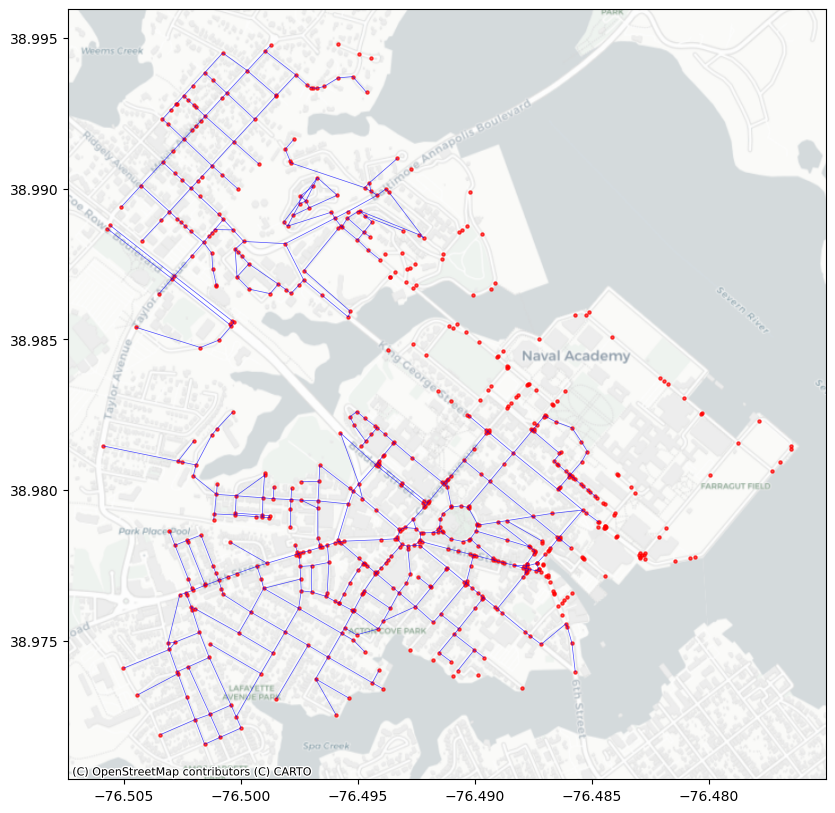

In [50]:
# Plot with basemap
fig, ax = plt.subplots(figsize=(20, 10))
edges_gdf.plot(ax=ax, linewidth=0.5, edgecolor="blue", alpha=0.7)
nodes_gdf.plot(ax=ax, markersize=5, color="red", alpha=0.7)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nodes_gdf.crs)

plt.show()

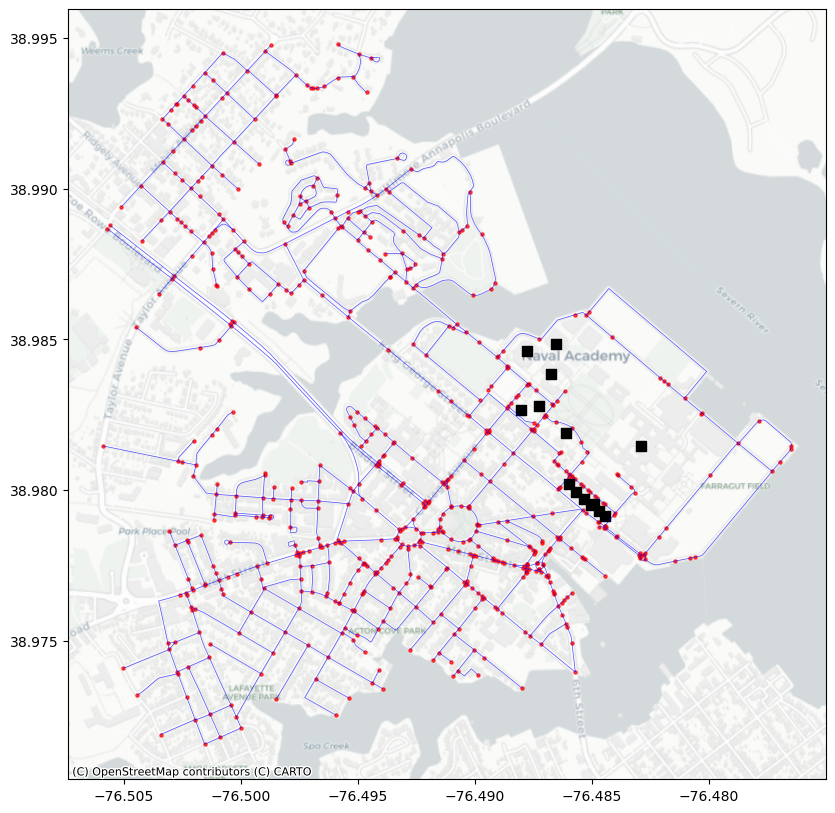

In [51]:
# Plot with basemap
fig, ax = plt.subplots(figsize=(20, 10))
edge_df.plot(ax=ax, linewidth=0.5, edgecolor="blue", alpha=0.7)
nodes_df.plot(ax=ax, markersize=5, color="red", alpha=0.7)
building_plot = buildings_df.plot(ax=ax, marker = 's', markersize=50, color = 'k')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nodes_gdf.crs)

plt.show()

### Plot Recovery Curves

#### Aggregated Recovery Curve

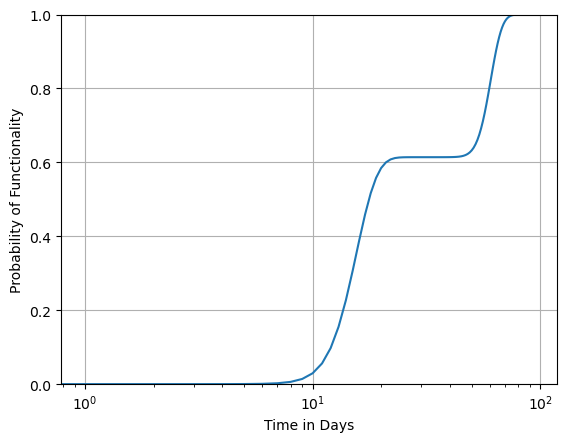

In [52]:
# Showing for a specific building
building_id = 6

time = buildings_df.loc[building_id, 'time']
functionality = buildings_df.loc[building_id, 'recov']

plt.xscale('log')
plt.plot(time, functionality)
plt.grid(True)
plt.ylim(0,1)
plt.xlim(0,np.max(time))
plt.xlabel('Time in Days')
plt.ylabel('Probability of Functionality')
# plt.legend()

plt.show()